In [30]:
import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt

In [17]:
instrument = pd.read_csv('data1m/final/BTCUSD_1min.csv')
instrument.drop('Unnamed: 0', axis=1, inplace=True)
instrument['date'] = instrument['t'].apply(lambda x: str(x)[:10])
instrument['t'] = instrument['t'].apply(lambda x: str(x)[11:])
instrument['returns'] = instrument['c'].pct_change().shift(-1)
instrument.drop_duplicates(inplace=True)

C:\Users\Hindy\AppData\Local\Temp\ipykernel_13592\332309790.py:1: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  instrument = pd.read_csv('data1m/final/BTCUSD_1min.csv')


In [18]:
df = list(instrument[['date', 't', 'c']].groupby('date'))

df2 = []
for d in [i[1] for i in df]:
    d.index = pd.to_datetime(d['t'])
    df2.append(d.drop_duplicates().resample('1min').ffill())
    
df = [d.drop('date', axis=1).set_index('t').sort_index() for d in df2]
df = [d for d in df if d.shape[0] == 1440]
df = np.vstack(df).reshape(-1, 1440, 1)

In [19]:
N = int(len(df) * .7)
train = df[:N].copy()
test = df[N:].copy()

In [20]:
y_train_ret = [(t[-1] - t[0])[0] for t in train]
y_train = pd.Series(y_train_ret)
y_train = np.where(y_train >= 0, 1, 0)

In [21]:
y_test_ret = [(t[-1] - t[0])[0] for t in test]
y_test = pd.Series(y_test_ret)
y_test = np.where(y_test >= 0, 1, 0)

In [22]:
scaler = TimeSeriesScalerMeanVariance()
scaler.fit(train)
X_train = scaler.transform(train)
X_test = scaler.transform(test)

In [23]:
X_train2 = pd.DataFrame(X_train.reshape(1122, 1440))
X_test2 = pd.DataFrame(X_test.reshape(482, 1440))

In [26]:
model = keras.Sequential()
model.add(keras.layers.LSTM(
    units=64,
    input_shape=(X_train.shape[1], X_train.shape[2])
))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
model.add(keras.layers.LSTM(units=64, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.2))
model.add(
  keras.layers.TimeDistributed(
    keras.layers.Dense(units=X_train.shape[2])
  )
)
model.compile(loss='mae', optimizer='adam')

In [27]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    shuffle=False
)


Epoch 1/10
32/32 [==============================] - 32s 954ms/step - loss: 0.5326 - val_loss: 0.5018
Epoch 2/10
32/32 [==============================] - 33s 1s/step - loss: 0.4922 - val_loss: 0.4864
Epoch 3/10
32/32 [==============================] - 35s 1s/step - loss: 0.4772 - val_loss: 0.4652
Epoch 4/10
32/32 [==============================] - 34s 1s/step - loss: 0.4703 - val_loss: 0.4651
Epoch 5/10
32/32 [==============================] - 34s 1s/step - loss: 0.4671 - val_loss: 0.4618
Epoch 6/10
32/32 [==============================] - 34s 1s/step - loss: 0.4664 - val_loss: 0.4607
Epoch 7/10
32/32 [==============================] - 35s 1s/step - loss: 0.4654 - val_loss: 0.4604
Epoch 8/10
32/32 [==============================] - 35s 1s/step - loss: 0.4653 - val_loss: 0.4627
Epoch 9/10
32/32 [==============================] - 35s 1s/step - loss: 0.4664 - val_loss: 0.4676
Epoch 10/10
32/32 [==============================] - 35s 1s/step - loss: 0.4701 - val_loss: 0.4713


In [40]:
list(history.history.items())[0][0]

'loss'

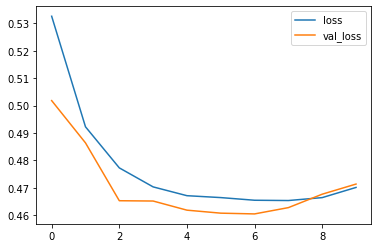

In [41]:
plt.plot(list(history.history.items())[0][1])
plt.plot(list(history.history.items())[1][1])
plt.legend(['loss', 'val_loss'])

In [42]:
X_train_pred = model.predict(X_train)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

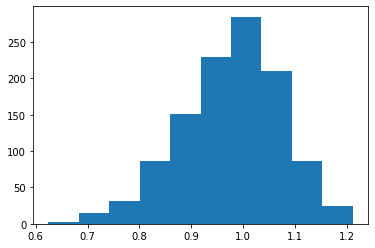

In [48]:
plt.hist(train_mae_loss)
plt.show()

In [49]:
train_mae_loss.std()

0.09743186973957113

In [46]:
X_test_pred = model.predict(X_test)
test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

In [62]:
X_train.shape

(1122, 1440, 1)

In [71]:
np.vstack([X_train.reshape(1122, 1440), X_test.reshape(482, 1440)]).shape

(1604, 1440)

In [75]:
df.reshape(1604 * 1440, -1).shape

(2309760, 1)

In [78]:
(train_mae_loss > .65).shape

(1122, 1)

In [77]:
(test_mae_loss > .65).shape

(482, 1)

In [91]:
482 * 1440

694080

In [100]:
autoencode_df = np.vstack([np.vstack([train_mae_loss for _ in range(1440)]), np.vstack([test_mae_loss for _ in range(1440)])])

In [142]:
df.reshape(1604 * 1440)[autoencode_df.reshape(1604 * 1440) > .99].shape

(1152000,)

In [136]:
np.arange(1604 * 1440)[autoencode_df.reshape(1604 * 1440) > .9]

array([      0,       1,       2, ..., 2309756, 2309757, 2309758])

In [131]:
range(1604 * 1440)

range(0, 2309760)

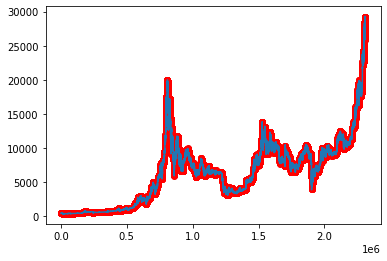

In [138]:
plt.plot(df.reshape(1604 * 1440))
plt.scatter(np.arange(1604 * 1440)[autoencode_df.reshape(1604 * 1440) > .99], df.reshape(1604 * 1440)[autoencode_df.reshape(1604 * 1440) > .99], color='red')

In [116]:
df.reshape(1604 * 1440).shape

(2309760,)